# Tutorial 4: Simulating plankton species

This tutorial is the first part of a two part tutorial series on how to use *simulated* plankton image datasets to train a deep learning model, to segment and classify plankton species. In this tutorial, we will use the [DeepTrack](https://github.com/softmatterlab/DeepTrack2) software package to simulate two plankton species: *Noctiluca scintillans* and *Dunaliella tertiolecta*.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/softmatterlab/Deep-learning-in-plankton-ecology/blob/main/segmentation-tutorials/4-simulating_planktons.ipynb)

Specifically, this tutorial will cover the following topics:
* Creating virtual microscope with DeepTrack
* Simulating plankton species with help of standard shapes such as Spheres and Point particles
* Imaging the simulated plankton species with a virtual microscope
* Creating ground truth segmentation masks for the simulated plankton species

In the next [tutorial](https://github.com/softmatterlab/Deep-learning-in-plankton-ecology/blob/main/segmentation-tutorials/5-training_UNet_segmentation.ipynb), we will see how to use the simulated images to train a U-Net model to segment and classify the two species.

**NOTE**:
- If you're running this notebook on your local machine, please comment the code in the cell below

In [1]:
!git clone https://github.com/softmatterlab/Deep-learning-in-plankton-ecology.git
%cd Deep-learning-in-plankton-ecology/segmentation-tutorials

## 1. Setup
Imports the required python packages needed to run this tutorial.

In [1]:
import sys

sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import deeptrack as dt

/Users/xbacss/Documents/GitHub/DeepTrack2/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/Users/xbacss/Documents/GitHub/DeepTrack2/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
2023-09-11 20:46:10.430464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Load the experimental image
In the following code, we will load an experimental image containing the species *Noctiluca scintillans* and *Dunaliella tertiolecta*. We will observe how the cells look in the image, and simulate a dataset that resembles the experimental image.

### 2.1. Create helper functions
We will begin by creating the helper function `center_crop` for the cropping the image to the area of interest.

In [2]:
def center_crop(image, center, window_size=20):
    """
    Crop an image around a center point.
    """
    x_center, y_center = center
    half_window = window_size // 2

    x_min = int(x_center - half_window)
    x_max = int(x_center + half_window)
    y_min = int(y_center - half_window)
    y_max = int(y_center + half_window)

    cropped_image = image[y_min:y_max, x_min:x_max]
    return cropped_image

### 2.2. Load the experimental image
Here we will load the experimental image, crop it the area of interest and plot it. You can see two plankton species in the image: *Noctiluca scintillans* at the center and smaller *Dunaliella tertiolecta* in the background.

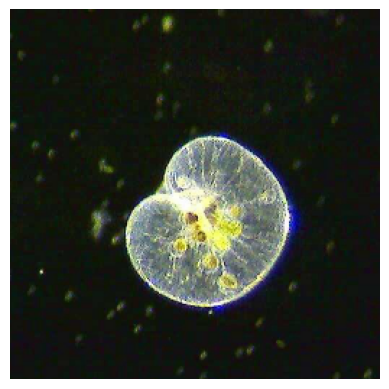

In [4]:
exp_image = np.array(Image.open("../data/noctiluca-data/noctiluca_exp_image.jpg"))

pos = [750, 450]

# Downsample the image using deeptrack average pooling
downsample = 2
exp_img = dt.Value(exp_image) >> dt.AveragePooling(ksize=(downsample, downsample, 1))
exp_img = exp_img.update()()

# Center crop the image at give pos
cropped_image = center_crop(
    exp_img, [pos[0] // downsample, pos[1] // downsample], window_size=256
)

# Plot the cropped image
plt.imshow(cropped_image.astype(np.uint8))
plt.axis("off")
plt.show()


## 3. Simulate images
Taking the above experimental image as inspiration, we will now create a simulated dataset containing both the plankton species.

The goal is train a `U-Net` model to segment the plankton species from the input image into two separate classes (Noctiluca and Dunaliella), by outputting two images of the same size as the input image, where each contains the area of interest for each plankton species.

### 3.1. Create microscopy objects
In the following cells, we will create different `python` objects from `deeptrack` software package ([DeepTrack](https://github.com/softmatterlab/DeepTrack2)) which we will use to simulate the images.
Specifically, we will create the following objects:
1. `optics`: Defines the optical properties of a virtual microscope that will be used to simulate the images.
2. `point_particle`: Defines the properties of a point particle that will be used to simulate the plankton species *Dunaliealla tertiolecta*.
3. `inner_spheres`: Defines the properties of the (inner) sphere that will be used to simulate the plankton species *Noctiluca scintillans*.
4. `outer_spheres`: Defines the properties of the (outer) sphere that will be used to simulate the plankton species *Noctiluca scintillans*. This will contribute to the halo around the plankton species that is observed in the experimental image.

We combine all these objects and perform some additional operations such as cropping, padding and normalization to create a final output of three images: `image`, `image_noctiluca` and `image_dunaliella`. The `image` is the final output image that we will use to train the neural network. The `image_noctiluca` and `image_dunaliella` are the ground truth images (binary masks) that we will use to train the neural network.

In [5]:
# Define the final image size
IMAGE_SIZE = 256

# Define the optical system
optics = dt.Fluorescence(
    wavelength=500e-9,
    NA=1.2,
    resolution=1e-6,
    magnification=12,
    refractive_index_medium=1.33,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
)

# Define point particles that represent plankton species, Dunaliella tertiolecta
point_particles = dt.Sphere(
    position=lambda: np.random.uniform(0, IMAGE_SIZE, 2),
    radius=lambda: np.random.uniform(0.2e-6, 0.4e-6),
    intensity=lambda: np.random.uniform(1, 1.5),
    z=lambda: np.random.uniform(-5, 5),
)

# Define inner spheres that represent plankton species, Noctiluca scintillans
inner_spheres = dt.Sphere(
    position=lambda: np.random.uniform(0, IMAGE_SIZE, 2),
    radius=lambda: np.random.uniform(2e-6, 5e-6),
    intensity=lambda: -1 * np.random.uniform(0.8, 1.2),
)

# Define outer spheres that represent plankton species, Noctiluca scintillans
outer_spheres = dt.Sphere(
    position=inner_spheres.position,
    radius=inner_spheres.radius * 1.1,
    intensity=inner_spheres.intensity * -1,
)

# Combine the inner and outer spheres to create a single plankton species
combined_spheres = inner_spheres >> outer_spheres

# Define the number of Dunaliealla and Noctiluca in the image
point_particles_in_image = lambda: np.random.randint(20, 30)
spheres_in_image = lambda: np.random.randint(1, 3)

# Define the transformations applied to the point particles (Dunaliella tertiolecta)
point_cells = (
    (point_particles ^ point_particles_in_image)
    >> dt.Pad(px=(5, 5, 5, 5))
    >> dt.ElasticTransformation(alpha=50, sigma=8, order=1)
    >> dt.CropTight()
    >> dt.Poisson(snr=3)
    # You can add more transformations here
)

# Define the transformations applied to the spheres (Noctiluca scintillans)
spherical_cells = (
    (combined_spheres ^ spheres_in_image)
    >> dt.Pad(px=(5, 5, 5, 5))
    >> dt.ElasticTransformation(alpha=50, sigma=8, order=1)
    >> dt.CropTight()
    >> dt.Poisson(snr=3)
    # You can add more transformations here
)

# Normalize the images: For noise approriate level of noise in the next step
normalization = dt.NormalizeMinMax(
    min=lambda: np.random.rand() * 0.4,
    max=lambda min: min + 0.1 + np.random.rand() * 0.5,
)

# Add Poisson noise to the image
noise = dt.Poisson(snr=lambda: np.random.uniform(30, 40), background=normalization.min)

# Define the final sample
sample = optics(point_cells & spherical_cells) >> normalization >> noise

# Write a function to extract massk for Noctiluca scintillans
def transf():
    def inner(scatter_mask):

        mask = scatter_mask.sum(-1) != 0
        output = np.zeros((*scatter_mask.shape[:2], 1))

        output[mask] = 1

        return output

    return inner

# Write a function to extract massk for Dunaliella tertiolecta
def transf2(circle_radius=3):
    def inner(image):
        X, Y = np.mgrid[: 2 * circle_radius, : 2 * circle_radius]
        CIRCLE = (X - circle_radius + 0.5) ** 2 + (
            Y - circle_radius + 0.5
        ) ** 2 <= circle_radius**2
        CIRCLE = CIRCLE[..., None]
        return CIRCLE

    return inner

# Apply the functions to the sample
masks1 = spherical_cells >> dt.SampleToMasks(
    transf, output_region=optics.output_region, merge_method="or", number_of_masks=1
)

masks2 = point_cells >> dt.SampleToMasks(
    transf2, output_region=optics.output_region, merge_method="or", number_of_masks=1
)

# Combine the sample and the masks
image_and_labels = sample & masks1 & masks2

### 3.2. Plot the simulated images
Here we define the function `generate_images` to sample out images and the corresponding masks belonging to different species.
We will use this function in the next notebook to train the neural network.

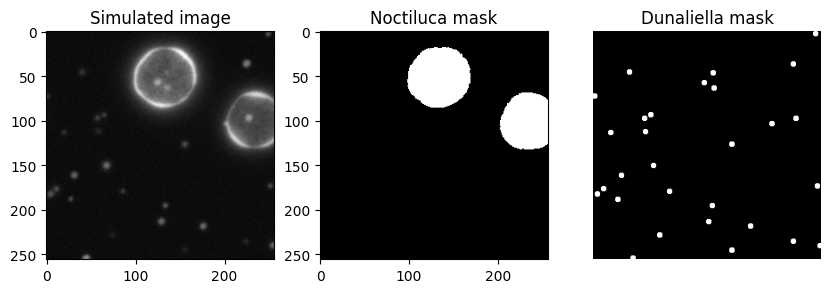

In [6]:
def generate_images():
    return image_and_labels


# Plot some example simulated images and masks
im, m1, m2 = generate_images().update()()

fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title("Simulated image")
plt.imshow(im, cmap="gray")
plt.subplot(1, 3, 2)
plt.title("Noctiluca mask")
plt.imshow(m1[..., 0], cmap="gray")
plt.subplot(1, 3, 3)
plt.title("Dunaliella mask")
plt.imshow(m2[..., 0], cmap="gray")
plt.axis("off")
plt.show()

In the next tutorial, [5-training_UNet_segmentation.ipynb](https://github.com/softmatterlab/Deep-learning-in-plankton-ecology/blob/main/segmentation-tutorials/5-training_UNet_segmentation.ipynb) we will use the simulated images (left most figure above) and the ground ruth masks (right) to train a U-Net model to segment the plankton species through a class segmentation task.